In [1]:
import keras.backend as K
import tensorflow as tf
from keras.layers import Input
from keras.activations import softplus
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import argparse
import keras.backend as K
import tensorflow as tf
import numpy as np
from keras.layers import Input, Reshape, Flatten,Dense,BatchNormalization,PReLU
from keras.layers import Activation, Add,Lambda,AveragePooling2D,LeakyReLU,GlobalAvgPool2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.initializers import RandomNormal,glorot_uniform
import pandas as pd
from keras.preprocessing.image import load_img
from tqdm import tqdm_notebook
conv_init = RandomNormal(0, 0.02)

Using TensorFlow backend.


In [2]:
def Resblock_generator(layer_input,channels):
    # h1 = BatchNormalization(momentum=0.9)(layer_input)
    h1 = UpSampling2D(size=2)(layer_input)
    h1 = Conv2D(channels,3,strides=1,padding="same",kernel_initializer=conv_init)(h1)
    # h1 = SubpixelConv2D(h1)(h1)
    h1 = BatchNormalization(momentum=0.9)(h1)
    # h1 = Activation("relu")(h1)

    h2 = UpSampling2D(size=2)(layer_input)
    h2 = Conv2D(channels,1,strides=1,padding="valid",kernel_initializer=conv_init)(h2)
    # h2 = SubpixelConv2D(layer_input)(h2)
    # h2 = Activation("relu")(h2)

    return Add()([h2,h1])

def Generator(z_dim,base=64):
    input = Input(shape=(z_dim,))
    h = Dense(128*8*8)(input)
    h = Reshape((8,8,128))(h)
    # h = Resblock_generator(h,base*4)
    # h = Resblock_generator(h,base*4)
    h = Resblock_generator(h,base*4)
    h = Resblock_generator(h,base*2)
    h = Resblock_generator(h,base)
    h = BatchNormalization(momentum=0.9)(h)
    h = PReLU()(h)
    h = Conv2D(3,3,strides=1,padding='same')(h)
    output = Activation('tanh')(h)
    model = Model(inputs=input,outputs=output)
    model.summary()
    return model

def Resblock_discriminator(layer_input,channels):
    h1 = Conv2D(channels,3,strides=1,padding='same',kernel_initializer=conv_init)(layer_input)
    h1 = LeakyReLU(alpha=0.2)(h1)
    h1 = Conv2D(channels,3,strides=1,padding='same',kernel_initializer=conv_init)(h1)
    h1 = AveragePooling2D(pool_size=(2, 2))(h1)

    h2 = Conv2D(channels,1,strides=1,padding="valid",kernel_initializer=conv_init)(layer_input)
    h2 = LeakyReLU(alpha=0.2)(h2)
    h2 = AveragePooling2D(pool_size=(2, 2))(h2)

    return Add()([h2,h1])

def Discriminator(input_shape,base=64):
    input = Input(shape=input_shape)
    h = Resblock_discriminator(input,base)
    h = Resblock_discriminator(h,base*2)
    h = Resblock_discriminator(h,base*4)
    # h = Resblock_discriminator(h,base*4)
    h = Resblock_discriminator(h,base*8)
    h = LeakyReLU(alpha=0.2)(h)
    # h = GlobalAvgPool2D()(h)
    h = Flatten()(h)
    # h = Dense(1024)(h)
    output = Dense(1)(h)
    model = Model(inputs=input,outputs=output)
    model.summary()
    return model

In [60]:
def combine_images(generated_images,row,col):
    num = generated_images.shape[0]
    width = col
    height = row
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1],3),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

In [56]:
def linspace_two(v1,v2,sample_nums):
    ans = [[0 for _ in range(sample_nums)] for i in range(np.shape(v1)[0])]
    for i in range(len(ans)):
        ans[i][:] = np.linspace(v1[i],v2[i],sample_nums)
    return np.array(ans).T

def linspace_four(lu,ru,ld,rd,sample_nums):
    lcol = linspace_two(lu,ld,sample_nums)
    rcol = linspace_two(ru,rd,sample_nums)
    ans = []
    for i in range(len(lcol)):
        ans.append(linspace_two(lcol[i],rcol[i],sample_nums))
    res = [_ for i in ans for _ in i]
    return np.array(res)

In [3]:
epochs = 50
save_interval = 1
model_interval = 1
batch_size = 32
_lambda = 0.5

z_dim = 100
img_shape = (64, 64, 3)
image_size = 64
channels = 3
lr_D = 2e-4
lr_G = 2e-4
b1 = 0.5
b2 = 0.99

gen = Generator(z_dim)
dis = Discriminator(img_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8192)         827392      input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 8, 8, 128)    0           dense_1[0][0]                    
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 16, 16, 128)  0           reshape_1[0][0]                  
__________________________________________________________________________________________________
up_samplin

In [7]:
gen.load_weights("./DRAGAN_model/model-40-epoch.h5")

In [96]:
noise = np.random.normal(size=(16, z_dim))

In [97]:
imgs = gen.predict(noise)
imgs = imgs/2 + 0.5

In [98]:
trial = 4
imgs = combine_images(imgs,4,4)

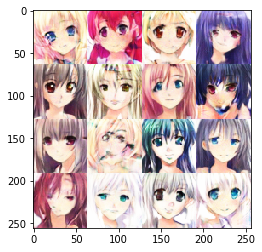

In [99]:
plt.imshow(imgs)
plt.imsave('./DRAGAN_result/Predict_{}.png'.format(trial),imgs)
plt.show()

In [101]:
v1 = noise[0]
v2 = noise[4]
v3 = noise[8]
v4 = noise[10]

In [102]:
noise_interpret = linspace_four(v1,v2,v3,v4,8)

In [103]:
imgs = gen.predict(noise_interpret)
imgs = imgs/2 + 0.5

In [104]:
imgs = combine_images(imgs,8,8)

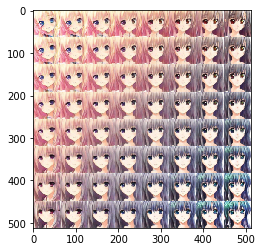

In [105]:
trial = 4
plt.imshow(imgs)
plt.imsave('./DRAGAN_result/inter_{}.png'.format(trial),imgs)
plt.show()